# Dog Breeds 
### Kaggle competition
![doggo](https://kaggle2.blob.core.windows.net/competitions/kaggle/7327/logos/header.png)

### Imports

NOTE: this notebook requires fastai lib to be in same dir
- can be done by symlinking fastai folder here
- same is done with the data folder\

In [126]:
# Put these at the top of every notebook, to get automatic reloading and inline plotting
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [127]:
# import fastai
from fastai.imports import *

In [128]:
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [5]:
ls fastai

fastai@


### CUDNN enabled

In [6]:
print(torch.cuda.is_available())
torch.backends.cudnn.enabled

True


True

#### set data and other config

In [11]:
PATH = "data/dog-breed-identification/"
arch=resnet34
sz=224
bs=64

### What do doggos look like

In [12]:
# create a validation set of id tags

label_csv = f'{PATH}labels.csv'
n = len (list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

In [13]:
label_df = pd.read_csv(label_csv)

In [14]:
label_df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [13]:
label_df.pivot_table(index='breed', aggfunc=len).sort_values('id', ascending=False).head()

,id
breed,
scottish_deerhound,126
maltese_dog,117
afghan_hound,116
entlebucher,115
bernese_mountain_dog,114


# Steps
- Enable data augmentation, and `precompute=True`
- Use `lr_find()` to find the highest learning rate where loss is still clearly improving
- Train last layer from precomputerd activations for **1-2 epochs**
- Train last layer with data augmentation (precompute false ) for **2-3 epochs** with `cycle_len=1`
- Unfreeze all layers
- Set earlier layers to `3x -10x` lower learning rate than next higher layer
- Use `lr_find()` again
- Train full network with `cycle_mult=2` until over-fitting

### 1.

In [107]:
def get_data(sz, bs, aug=False):
    
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
    data = ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                   val_idxs=val_idxs, suffix='.jpg', bs=bs) if not aug else ImageClassifierData.from_csv(PATH, 'train', f'{PATH}labels.csv', test_name='test',
                                   val_idxs=val_idxs, suffix='.jpg', tfms=tfms, bs=bs) 
    return data if sz > 300 else data.resize(340, 'tmp')

In [95]:
# grab pretrained learner object with data etc
data = get_data(64, 40, aug=True)
learn = ConvLearner.pretrained(resnet34, data, precompute=True)

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [79]:
learn.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

 89%|████████▉ | 182/205 [00:03<00:00, 60.50it/s, loss=19.9]


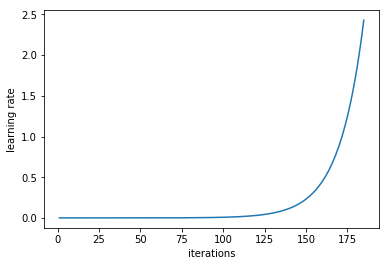

In [80]:
learn.sched.plot_lr()

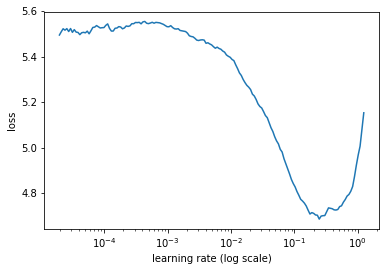

In [81]:
learn.sched.plot(n_skip_end=10)

In [43]:
1e-1

0.1

In [96]:
learn.fit(1e-2, 2)

HBox(children=(IntProgress(value=0, description='Epoch', max=2), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.663788   3.068012   0.283173  
    1      3.011809   2.841881   0.30625                    


[2.8418813, 0.3062500008023702]

In [97]:
learn.precompute=False

In [98]:
learn.fit(1e-2, 3, cycle_len=1)

HBox(children=(IntProgress(value=0, description='Epoch', max=3), HTML(value='')))

 31%|███       | 63/205 [00:05<00:11, 12.39it/s, loss=2.96]

Exception in thread Thread-39:
Traceback (most recent call last):
  File "/opt/conda/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/opt/conda/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/opt/conda/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



epoch      trn_loss   val_loss   accuracy                   
    0      2.935738   2.76905    0.329808  
    1      2.942398   2.73655    0.325                      
    2      2.786907   2.699749   0.333173                   



[2.6997488, 0.33317307755351067]

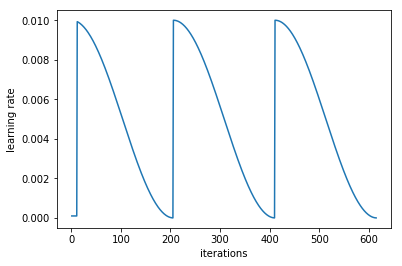

In [99]:
learn.sched.plot_lr()

In [105]:
64*2, 128*2, 299

(128, 256, 299)

In [108]:
learn.set_data(get_data(128, 40, aug=True))

HBox(children=(IntProgress(value=0, max=6), HTML(value='')))

In [121]:
log_preds = learn.predict()

In [124]:
preds = np.exp(log_preds)

In [166]:
# get the col names for predictions
breed_col = label_df.sort_values(by=['breed'])
np_breed = np.array(breed_col['breed'])
uniq_breeds = np.unique(np_breed)
uniq_breeds[:5]

array(['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier'],
      dtype=object)

In [168]:
csv_headers = np.insert(uniq_breeds, 0, 'id', axis=0); submission_headers[:5]

array(['id', 'affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale'], dtype=object)

In [176]:

df = pd.DataFrame(data=preds, columns=uniq_breeds); df.head()
df.insert(loc=0, column='id', value=label_df['id']); df.head()



,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000bec180eb18c7604dcecc8fe0dba07,0.012898,0.000951,0.005601,0.000781,0.002873,0.001933,0.004344,0.001347,0.000907,...,0.003104,0.045726,0.000168,0.001487,0.000578,0.000866,0.008266,0.001082,0.006615,0.003949
1,001513dfcb2ffafc82cccf4d8bbaba97,0.000909,0.000292,0.000806,0.006456,0.002854,0.005027,0.000851,0.000226,0.002637,...,0.001030,0.001060,0.000874,0.012844,0.005065,0.001019,0.000882,0.001997,0.008431,0.000395
2,001cdf01b096e06d78e9e5112d419397,0.004214,0.000386,0.002164,0.000700,0.023898,0.007196,0.000918,0.028474,0.002189,...,0.000776,0.068873,0.001705,0.013104,0.003783,0.000602,0.004009,0.027701,0.005651,0.000184
3,00214f311d5d2247d5dfe4fe24b2303d,0.001674,0.003899,0.000040,0.000292,0.000330,0.001231,0.003013,0.012639,0.000276,...,0.000133,0.001504,0.000058,0.000329,0.000102,0.000684,0.001746,0.001577,0.009027,0.002226
4,0021f9ceb3235effd7fcde7f7538ed62,0.010208,0.000312,0.000119,0.000955,0.000404,0.000422,0.005113,0.001181,0.000451,...,0.017478,0.001646,0.001233,0.000836,0.002297,0.000337,0.041788,0.000662,0.000250,0.011010


In [170]:
df;

In [91]:
learn.unfreeze()

In [92]:
lrs=np.array([1e-4, 1e-3, 1e-2])

In [94]:
learn.fit(lrs, 3, cycle_len=1, cycle_mult=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=7), HTML(value='')))

epoch      trn_loss   val_loss   accuracy                   
    0      3.297167   3.174204   0.249038  
    1      2.973362   2.824241   0.301442                   
    2      2.593904   2.745008   0.325                      
    3      2.601205   2.63029    0.348558                   
    4      2.326186   2.558223   0.356731                   
    5      2.082505   2.491355   0.375962                   
 13%|█▎        | 27/205 [00:07<00:49,  3.58it/s, loss=2]   

KeyboardInterrupt: 

In [ ]:
learn.sched.plot_lr()

In [ ]:
learn.save('64_full')

In [ ]:
learn.load('64_full')